Black Scholes Merton for option pricing

1- model the data using normal dist as described by BSM
2- find the 95% CI vals for data in time t
3- make a function for BSM and find price of an option
4- graph the option price vs diff parameters

[*********************100%***********************]  1 of 1 completed


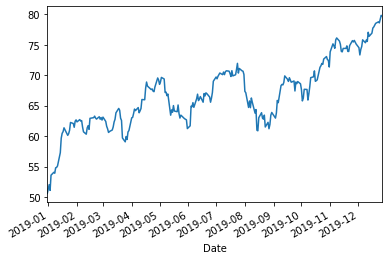

In [34]:
# initialization cell
from pandas_datareader import data, wb
#from nsepy import get_history as nse
import pandas as pd
import numpy as np
#nsepy dint work.. so yf
import yfinance as yf
import datetime
import matplotlib.pyplot as plt

%matplotlib inline

#citibank
data = yf.download(tickers="C",  period="1y",  interval="1d")['Adj Close']

data.plot()

In [35]:
# ret
returns = data.pct_change()
returns=returns.dropna()

In [36]:
#stats
print("mean = {}".format(np.mean(returns)))
print ("std dev = {}".format(np.std(returns)))
print ("min = {}".format(np.min(returns)))
print ("max = {}".format(np.max(returns)))
print ("skewness = {}".format(returns.skew()))
print ("excess kurtosis = {}".format(returns.kurtosis()))

mean = 0.001934478853728005
std dev = 0.015410839136084993
min = -0.05275337198567609
max = 0.052227993561571706
skewness = -0.11332609934723703
excess kurtosis = 1.6651932777399563


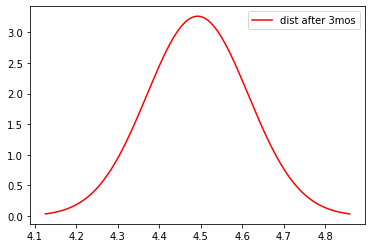

mean = 4.492284188363484 and std dev =0.12231974354670712 for ln S after 3mos


In [177]:
#parametrics using BSM assumption
#prob of underlying (stock) is normally dist.
#mean = (ln So + (mean -var/2)*T)
#Std dev= std*t^0.5

#say prob dist in next 3 mos?   t=.25!
t=.25
#chg daily mean to annual mean
ann_mean=np.mean(returns)*252
ann_std=np.std(returns)*(252**0.5)

#mean and std for normal curve
mn= np.log(data[-1]) + (ann_mean - ann_std**2/2)*t
std=ann_std *(t**0.5)

xs=np.linspace((mn-3*std),(mn+3*std),250)
y=stats.norm.pdf(xs,mn,std)
plt.plot(xs,y,color='red',label="dist after 3mos")
plt.legend()
plt.show()
print ("mean = {} and std dev ={} for ln S after 3mos".format(mn,std))
#this is the dist of ln of Stock in 3mos

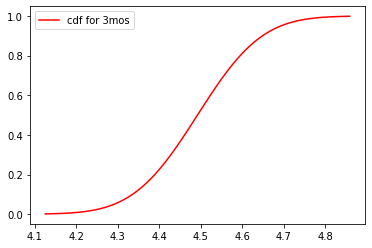

In [176]:
#cdf
xs=np.linspace((mn-3*std),(mn+3*std),250)
y_cdf=stats.norm.cdf(xs,mn,std)
plt.plot(xs,y_cdf,color='red',label="cdf for 3mos")
plt.legend()
plt.show()

In [188]:
#price of stock after 3mos with 95% CI
alpha=.05/2  #since its 2 sided
z=stats.norm.ppf(alpha,0,1) * (-1)
high= mn+(z*std)
low=mn-(z*std)

#converting ln back
high= np.exp(high)
low=np.exp(low)

print("current price={}".format(data[-1]))
print("95% CI in 3 mos is between {} and {}".format(high,low))



current price=79.66999816894531
95% CI in 3 mos is between 113.52538636360383 and 70.28383971879404


In [152]:
#function for BSM
def opt(S,X,r,t,vol1,type_opt='lc'):
    ''' spot,strike,rf,time,vol,type='lc' '''
        
    vol=vol1*(252**0.5) #chg from daily to annual vol
    d1=(np.log(S/X) + (r + (vol**2/2)) )/(vol*(t**0.5))
    d2=d1-vol*t**.5
    
    #long call --> lc
    type_dict={'lc': (S*stats.norm.cdf(d1) - X*stats.norm.cdf(d2)/np.exp(t*r)),
              'lp':  (X*stats.norm.cdf(-1*d2)/np.exp(t*r)- S*stats.norm.cdf(-1*d1)),
              'sc': (X*stats.norm.cdf(d2)/np.exp(t*r) - S*stats.norm.cdf(d1)) ,
              'sp': (S*stats.norm.cdf(-1*d1)- X*stats.norm.cdf(-1*d2)/np.exp(t*r))}
    return (type_dict[type_opt])


In [156]:
#function for BSM

#d1 & d2
def d1d2(S,X,r,t,vol1):
    vol=vol1*(252**0.5) #chg from daily to annual vol
    d1=(np.log(S/X) + (r + (vol**2/2)) )/(vol*(t**0.5))
    d2=d1-vol*t**.5
    return(d1,d2) # d2 is the prob that option will end up ITM.

def opt(S,X,r,t,vol1,type_opt='lc'):
    ''' spot,strike,rf,time,vol,type='lc' '''
    (d1,d2)=d1d2(S,X,r,t,vol1)
    
    #long call --> lc
    type_dict={'lc': (S*stats.norm.cdf(d1) - X*stats.norm.cdf(d2)/np.exp(t*r)),
              'lp':  (X*stats.norm.cdf(-1*d2)/np.exp(t*r)- S*stats.norm.cdf(-1*d1)),
              'sc': (X*stats.norm.cdf(d2)/np.exp(t*r) - S*stats.norm.cdf(d1)) ,
              'sp': (S*stats.norm.cdf(-1*d1)- X*stats.norm.cdf(-1*d2)/np.exp(t*r))}
    return (type_dict[type_opt])



In [159]:
# lets test it

# spot as current share price and strike at 5% more
#vol is derived from the stock itself and not assumed. 
#rf and time are assumed and are annual
test = opt(data[-1],data[-1]*1.05,.05,.25,np.std(returns),'lc')
d1,d2= d1d2(data[-1],data[-1]*1.05,.05,.25,np.std(returns))

print ("the price of option= {} and prob that it will end up ITM = {}".format(test,d2))

the price of option= 2.186462508295797 and prob that it will end up ITM = 0.13221050848365273


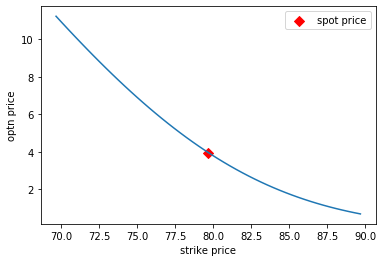

In [113]:
# opt price vs strike price for long call
v=np.linspace(data[-1]-10,data[-1]+10,50)
op=[]
op=opt(data[-1],v,.05,.25,np.std(returns),'lc')
plt.plot(v,op)
plt.scatter(x=data[-1],y=(opt(data[-1],data[-1],.05,.25,np.std(returns),'lc')), 
            c='red', marker='D', s=50,label="spot price")
plt.xlabel('strike price')
plt.ylabel('optn price')
plt.legend()
plt.show()

# as X goes up, optn becomes deep OTM, hence price goes down

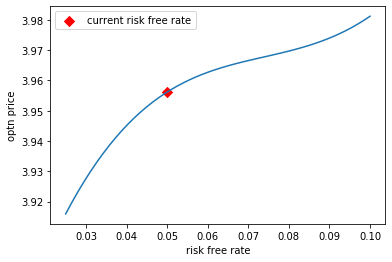

In [136]:
# price vs risk free rate where X = S*1.05
rf=.05
v=np.linspace(rf*.5,rf*2,50)
op=[]
op=opt(data[-1],data[-1],v,.25,np.std(returns),'lc')

plt.plot(v,op)
plt.scatter(x=rf,y=(opt(data[-1],data[-1],rf,.25,np.std(returns),'lc')),
            c='red', marker='D', s=50,label="current risk free rate")
plt.xlabel('risk free rate')
plt.ylabel('optn price')
plt.legend()
plt.show()

#as rf increases, option cost inc

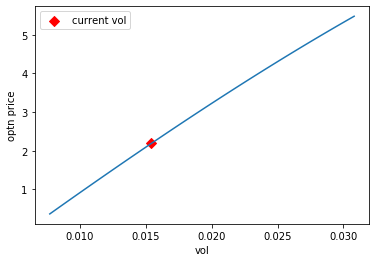

In [124]:
# price vs vol
vol=np.std(returns)
v=np.linspace(vol*.5,vol*2,50)
op=[]
op=opt(data[-1],data[-1]*1.05,.05,.25,v,'lc')
plt.plot(v,op)
plt.scatter(x=vol,y=(opt(data[-1],data[-1]*1.05,.05,.25,vol,'lc')),
            c='red', marker='D', s=50,label="current vol")
plt.xlabel('vol')
plt.ylabel('optn price')
plt.legend()
plt.show()

#volitality will increase option price as it becomes less predictable